# MAX CUT Problem 
Define the Graph Model with drawing methods

In [300]:
import numpy as np
import networkx as nx  # tool to handle general Graphs 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from typing import Any, Dict, List, Tuple
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

In [506]:
# Firstly, we define a class we can draw a graph in convinient way

class GraphModel:
    
    n_qubits: int
    edges: List[Tuple[int, int]]
    graph: nx.Graph
          
    def __init__(self, n_qubits, edges, qaoa_solve=None):
        
        self.n_qubits = n_qubits
        self.edges = edges
        self.graph = nx.Graph()
        self.graph.add_nodes_from(np.arange(0,n_qubits,1))
        self.graph.add_edges_from(edges)
        self.qaoa_solve = qaoa_solve
        
    def draw_raw_graph(self):
        
        # Generate plot of the  Graph
        colors       = ['hotpink' for node in self.graph.nodes()]
        default_axes = plt.axes(frameon=False)
        random_pos = nx.random_layout(self.graph, seed=42)
        pos = nx.spring_layout(self.graph, pos=random_pos)

        nx.draw_networkx_nodes(self.graph, node_color=colors, node_size=1300,pos = pos, 
                    alpha=1, ax=default_axes)       
        nx.draw_networkx_edges(self.graph, pos = pos, width=8,alpha=1,ax=default_axes,
                               edge_color="tab:grey")
        nx.draw_networkx_labels(self.graph, pos = pos, font_size=22, font_color="whitesmoke")

    def draw_done_graph(self,bitstring):
        
        # Draw a graph in accordance with its bitstring
        color_map = []
        edgelist_different  = []
        edgelist_same  = []
        default_axes = plt.axes(frameon=False)
        default_axes.axis('off')
        random_pos = nx.random_layout(self.graph, seed=42)
        pos = nx.spring_layout(self.graph, pos=random_pos)
        
        if bitstring == None:
            self.draw_raw_graph()
        else:
            for i in bitstring:
                if i > 0:
                    color_map.append('blue')
                else: 
                    color_map.append('hotpink')
            for edge in self.edges:
                if bitstring[edge[0]] != bitstring[edge[1]]:
                    edgelist_different.append(edge)
                else:
                    edgelist_same.append(edge)
                    
            nx.draw_networkx_nodes(self.graph, node_color=color_map, node_size=1300,pos = pos, 
                    alpha=1, ax=default_axes)       
            nx.draw_networkx_edges(self.graph, pos = pos, edgelist = edgelist_same, 
                                   width=8,alpha=1,ax=default_axes,edge_color="tab:grey")
            nx.draw_networkx_edges(self.graph, pos = pos, edgelist = edgelist_different,
                                   width=8,alpha=1,ax=default_axes, edge_color="tab:red")
            nx.draw_networkx_labels(self.graph, pos = pos, font_size=22, font_color="whitesmoke")

In [507]:
def graph_drawing(G,regime, *args, **kwargs):
    bitstring = kwargs.get('bitstring', None)
    filename = kwargs.get('filename', None)
    figure, axes = plt.subplots(frameon=False)
    axes.axis('off')
    # Turn off tick labels
    req_dpi = 72  # ADDED
    figure.set_size_inches(1000 / float(req_dpi),  # MODIFIED
                           1000 / float(req_dpi)) 
    if regime == 'raw':
        G.draw_raw_graph()
    elif regime == 'done':
        G.draw_done_graph(bitstring)
    else:
        raise ValueError('Regime is wrong')
        
    figure.savefig(filename, format='png',
               transparent=True, dpi=req_dpi) 

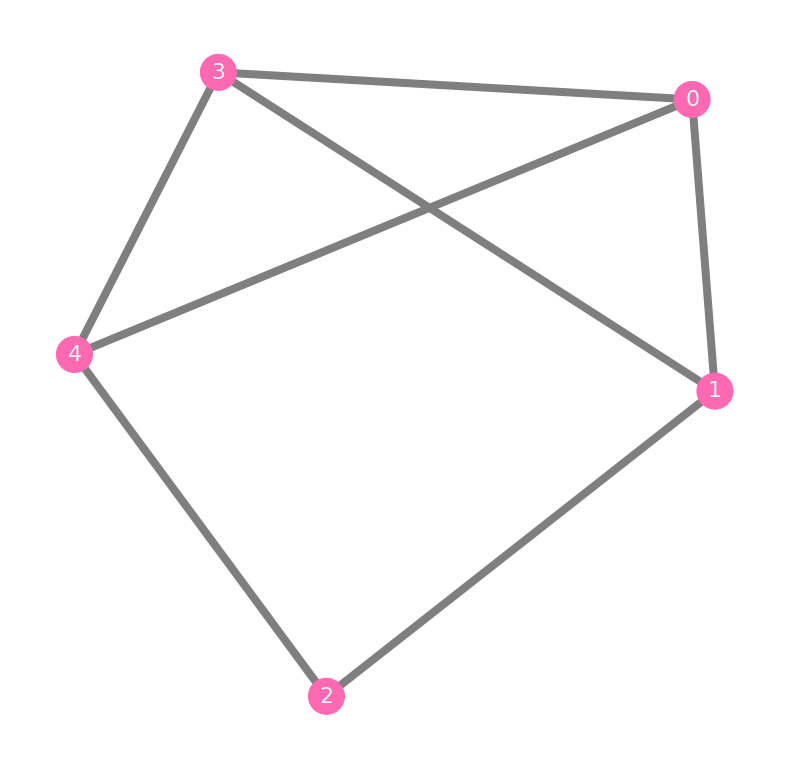

In [508]:
# Example of drawing method of the class GrapgModel

E = [(0, 1),(0,3),(0,4), (1,3), (1, 2),(2,1),(2,4),(4,3)]
G = GraphModel(5,E)
graph_drawing(G,'raw',filename = 'graph_model11.png')


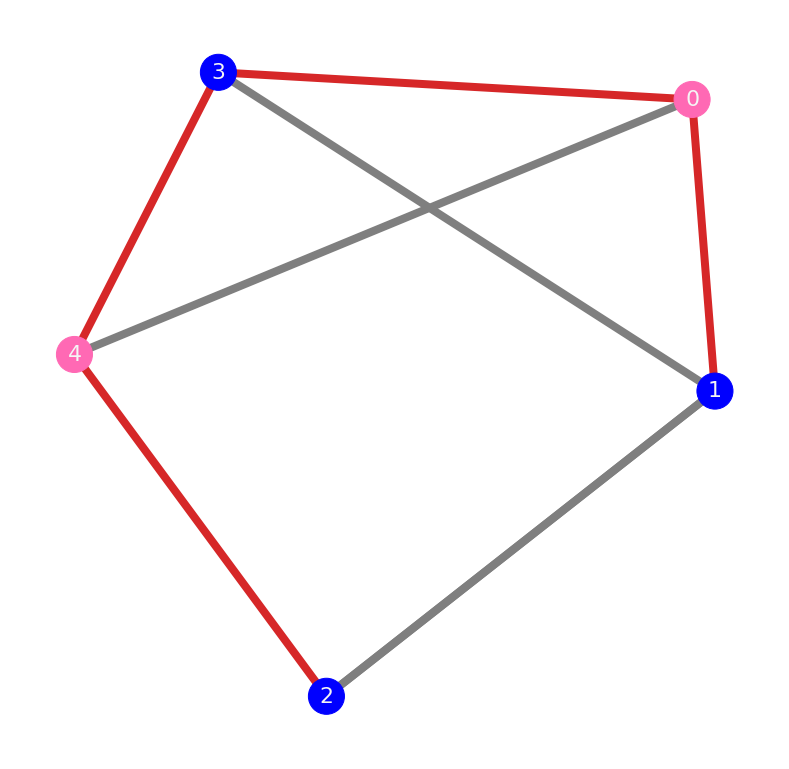

In [509]:
graph_drawing(G,'done',bitstring = [0,1,1,1,0],filename = 'graph_model22.png')

In [510]:
G.graph

# Drawing the circuit for p = 1, i.e only 2 parameters

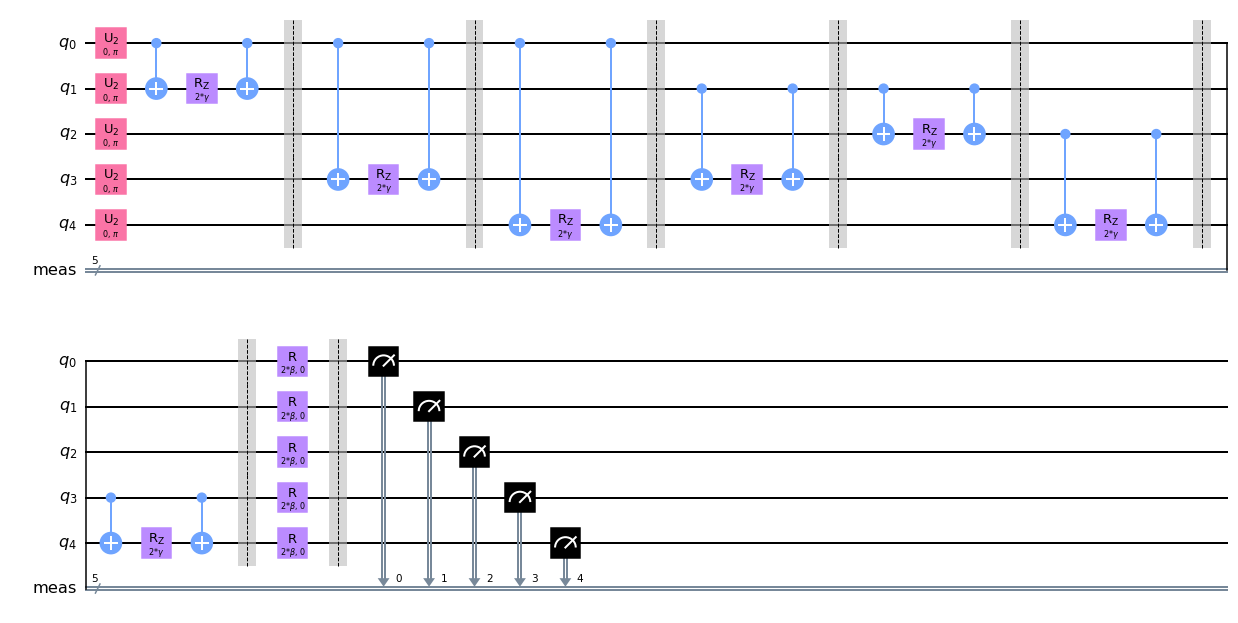

In [511]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

nqubits = 5
E = [(0, 1),(0,3),(0,4), (1,3), (1, 2),(2,1),(2,4),(4,3)]
G = GraphModel(5,E).graph
# Drawing the circuit for p=1
beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)

gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()

qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)

qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])
qc_qaoa.measure_all()
qc_qaoa.decompose().decompose().draw("mpl")

In [512]:
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram

In [513]:
def maxcut_obj(x, G):

#     Given a bitstring as a solution, this function returns
#     the number of edges shared between the two partitions
#     of the graph.

#     Args:
#         x: str
#            solution bitstring

#         G: networkx graph

#     Returns:
#         obj: float
#              Objective

    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
    return obj


def compute_expectation(counts, G):

    """
    Computes expectation value based on measurement results

    Args:
        counts: dict
                key as bitstring, val as count

        G: networkx graph

    Returns:
        avg: float
             expectation value
    """

    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():

        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count

    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):

#     """
#     Creates a parametrized qaoa circuit

#     Args:  
#         G: networkx graph
#         theta: list
#                unitary parameters

#     Returns:
#         qc: qiskit circuit
#     """

    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)

    beta = theta[:p]
    gamma = theta[p:]

    # initial_state
    for i in range(0, nqubits):
        qc.h(i)

    for irep in range(0, p):

        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)

    qc.measure_all()

    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, shots=512):

#         """
#         Runs parametrized circuit

#         Args:
#             G: networkx graph
#             p: int,
#                Number of repetitions of unitaries
#         """

    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):

        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()

        return compute_expectation(counts, G)

    return execute_circ

def optimization(G,initial_parameters):
    expectation = get_expectation(G)

    res = minimize(expectation, initial_parameters, method='COBYLA')

    return res

# Firstly, we consider "middle model" with 5 nodes

In [514]:
# Graph description for the certain task
qubits = 5
E = [(0, 1),(0,3),(0,4), (1,3), (1, 2),(2,1),(2,4),(4,3)]
G_model = GraphModel(5,E)
G = G_model.graph

In [515]:
class QAOA:
    counts: dict
    def __init__(self, graph, initial_parameters):
        self.graph = graph
        self.initial_parameters = initial_parameters
        
        backend = Aer.get_backend('aer_simulator')
        backend.shots = 512
        qc_res = create_qaoa_circ(graph, optimization(graph,initial_parameters).x)
        counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
        self.counts = counts
    
    def result(self):
        pass

In [516]:
p = 10
initial_parameters = [1.0,1.0]*p
model = QAOA(G,initial_parameters)
counts = model.counts

In [517]:
plot_histogram(model.counts, figsize=(16, 10), color=None, number_to_keep=None,
               sort='asc', target_string=None, legend=None,
               bar_labels=True, title="Final Distribution", ax=None, filename="final_distr5")

# Calculating the performance for the given graph

In [518]:
def cost_function_C(x,G):
    
    # Calculating the cost function for our task 
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    # here we are checking all the pairs
    for index in E: 
        e1 = index[0]
        e2 = index[1]
        
        w      = G[e1][e2]
        C = C + x[e1]*(1-x[e2]) + x[e2]*(1-x[e1])
        
    return C

In [519]:
# Class for conviniet operations with results 
class SimResult:
    
    def __init__(self, counts, graph):
        
        self.counts = counts
        self.graph = graph
    
    def calc_result(self):
        
        avr_C       = 0
        max_C       = [0,0]
        hist        = {}
        shots = 512
        for sample in list(self.counts.keys()):

            # use sampled bit string x to compute C(x)
            x         = [int(num) for num in list(sample)]
            tmp_eng   = cost_function_C(x,self.graph)

            # compute the expectation value and energy distribution
            avr_C     = avr_C    + self.counts[sample]*tmp_eng # counts[sample]/shots is probability
            hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + self.counts[sample]

            # save best bit string
            if( max_C[1] < tmp_eng):
                max_C[0] = sample
                max_C[1] = tmp_eng

        M1_sampled   = avr_C/shots
        
        self.found_solution = list(map(int,list(max_C[0])))
        self.max_cost_function = max_C[1]
        
    def show_result(self):
    
        print('\n --- SIMULATION RESULTS ---\n')
        #print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
        print('The approximate solution is x* = %s with C(x*) = %d \n' % 
              (self.found_solution,self.max_cost_function))


In [520]:
simresult = SimResult(counts,G)
simresult.calc_result()
simresult.show_result()


 --- SIMULATION RESULTS ---

The approximate solution is x* = [0, 1, 0, 0, 1] with C(x*) = 6 



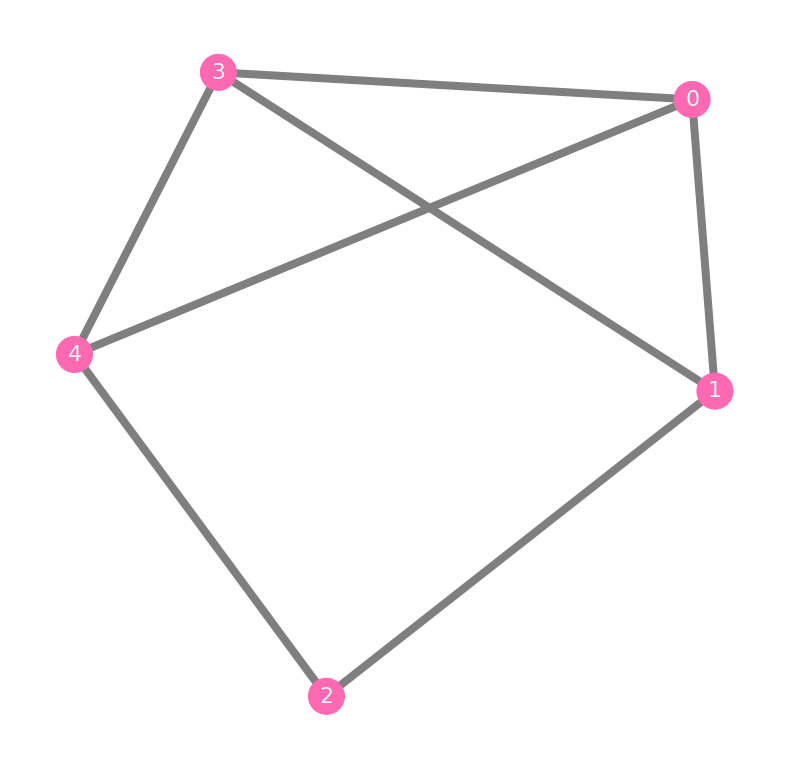

In [521]:
graph_drawing(G_model,'raw',bitstring = a,filename = 'raw_5raph6.png')

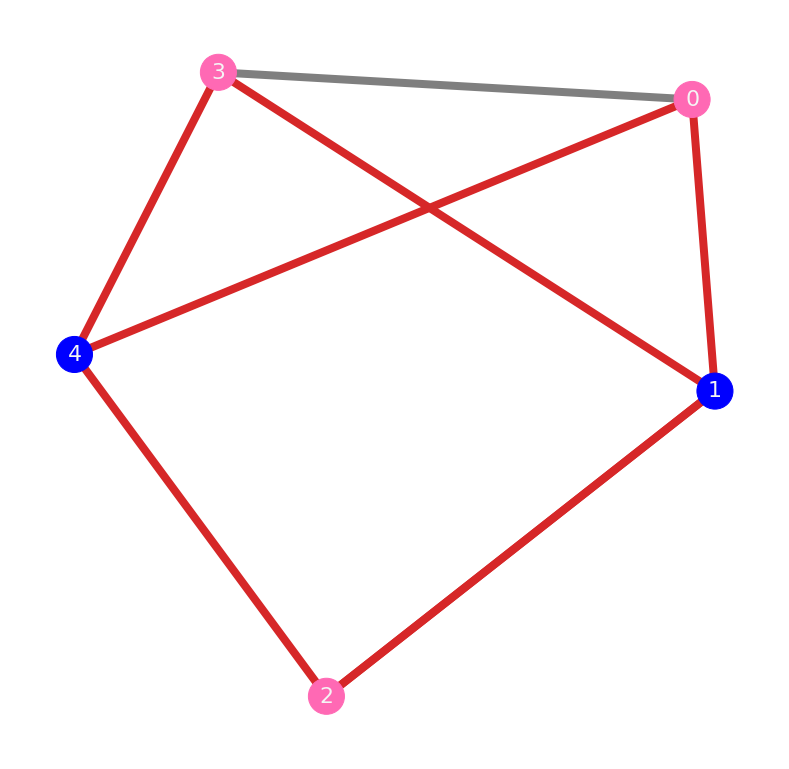

In [522]:
a = list(map(int,list(simresult.found_solution)))
graph_drawing(G_model,'done',bitstring = a,filename = 'done_graph5.png')

## Consider futher the model with 4 nodes 

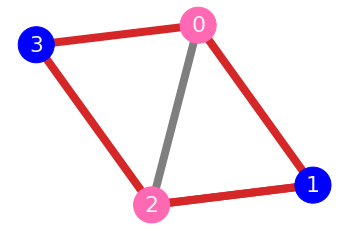

In [540]:
# Graph description for the certain task
n_qubits = 4
E = [(0, 1),(0,3),(2,0),(2,3), (1, 2),(2,1)]
G_model_4 = GraphModel(n_qubits,E)
G_4 = G_model_4.graph
G_model_4.draw_done_graph([0,1,0,1])

In [524]:
p = 10
initial_parameters = [1.0,1.0]*p
model = QAOA(G_4,initial_parameters)
counts = model.counts

In [525]:
plot_histogram(model.counts, figsize=(16, 10), color=None, number_to_keep=None,
               sort='asc', target_string=None, legend=None,
               bar_labels=True, title="Final Distribution", ax=None, filename="final_distr4")

In [526]:
simresult = SimResult(counts,G_4)
simresult.calc_result()
simresult.show_result()


 --- SIMULATION RESULTS ---

The approximate solution is x* = [0, 1, 0, 1] with C(x*) = 4 



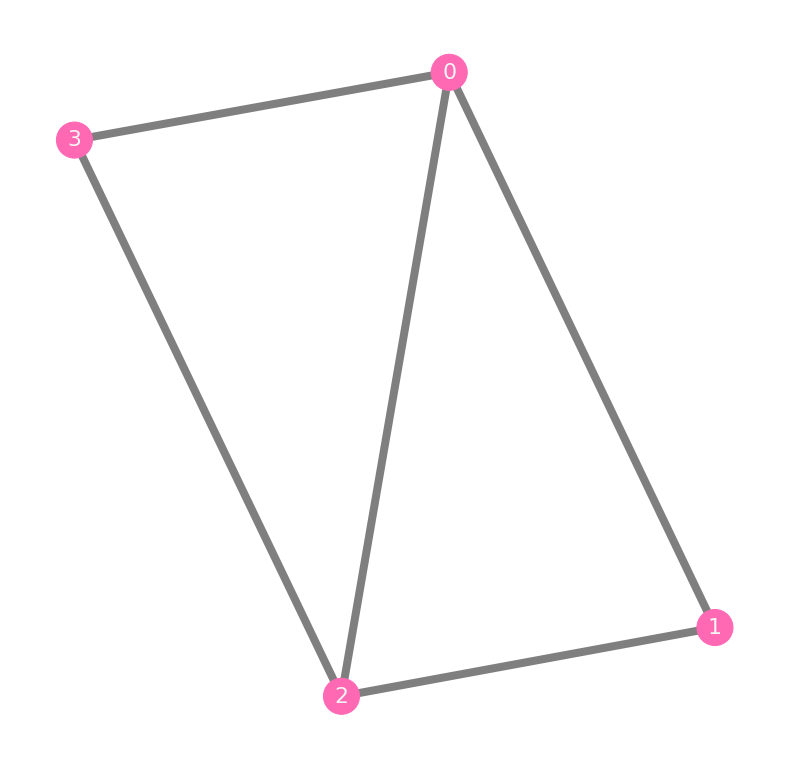

In [527]:
graph_drawing(G_model_4,'raw',bitstring = a,filename = 'raw_graph4.png')

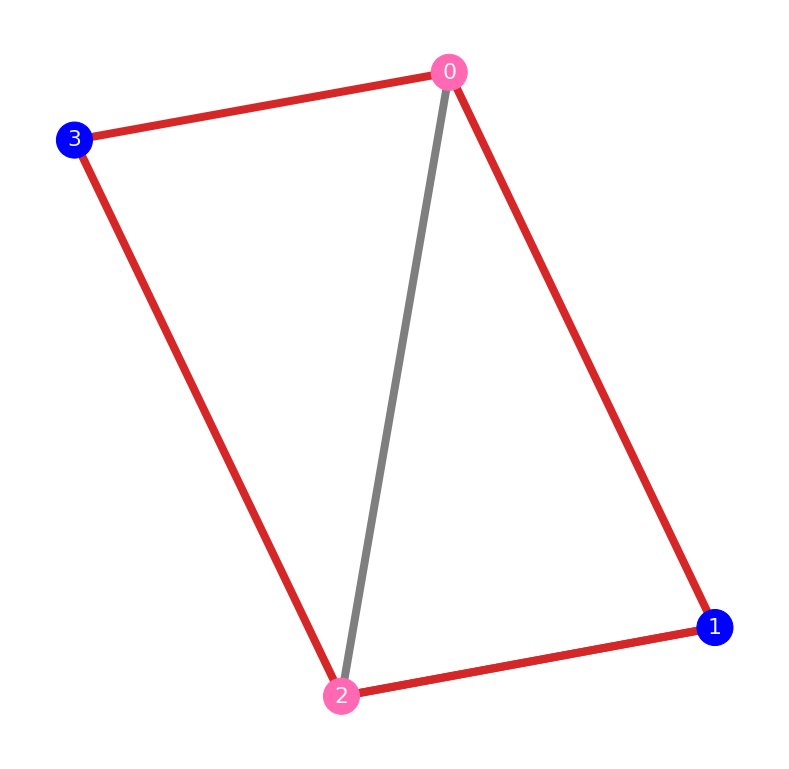

In [528]:
a = list(map(int,list(simresult.found_solution)))
graph_drawing(G_model_4,'done',bitstring = a,filename = 'done_graph4.png')

In [529]:
plot_histogram(model.counts, figsize=(16, 10), color=None, number_to_keep=None,
               sort='asc', target_string=None, legend=None,
               bar_labels=True, title="Final Distribution", ax=None, filename="final_distr4")

# Now we can investigate the graph with 6 nodes

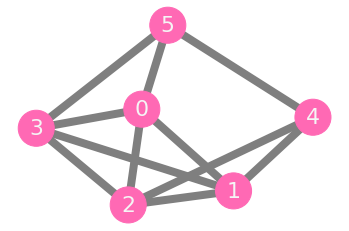

In [530]:
# Graph description for the certain task
n_qubits = 6
E = [(0, 1),(0,3),(2,0),(2,3),(3,1), (1, 2),(2,1),(1,4),(2,4),(0,5),(3,5), (4,5),]
G_model_6 = GraphModel(n_qubits,E)
G_6 = G_model_6.graph
G_model_6.draw_raw_graph()

In [531]:
p = 10
initial_parameters = [1.0,1.0]*p
model = QAOA(G_6,initial_parameters)
counts = model.counts

In [532]:
simresult = SimResult(counts,G_6)
simresult.calc_result()
simresult.show_result()


 --- SIMULATION RESULTS ---

The approximate solution is x* = [1, 0, 0, 1, 1, 0] with C(x*) = 9 



In [533]:
plot_histogram(model.counts, figsize=(16, 10), color=None, number_to_keep=None,
               sort='asc', target_string=None, legend=None,
               bar_labels=True, title="Final Distribution", ax=None, filename="final_distr6")

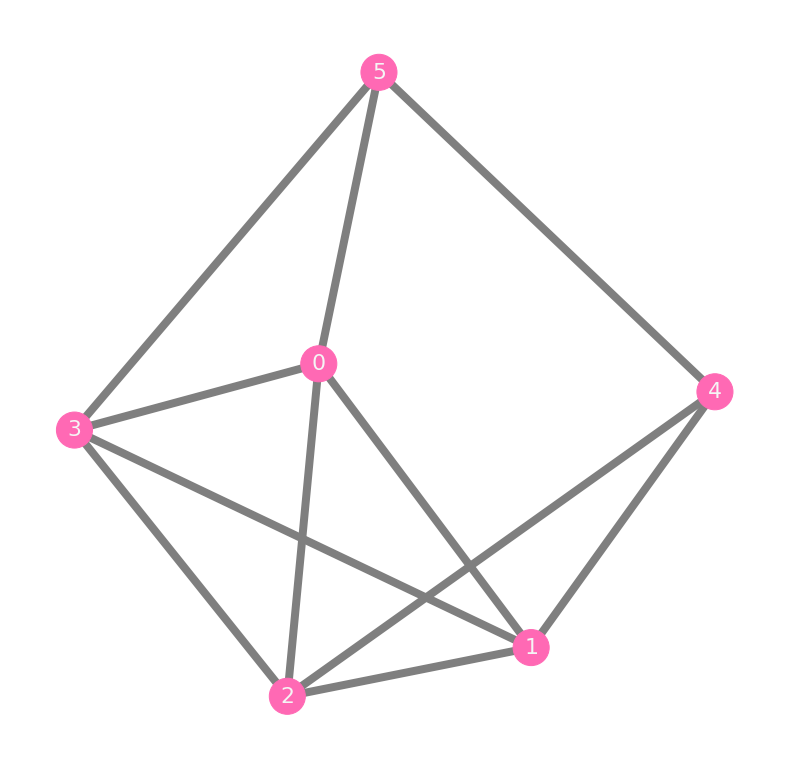

In [534]:
graph_drawing(G_model_6,'raw',bitstring = a,filename = 'raw_graph6.png')

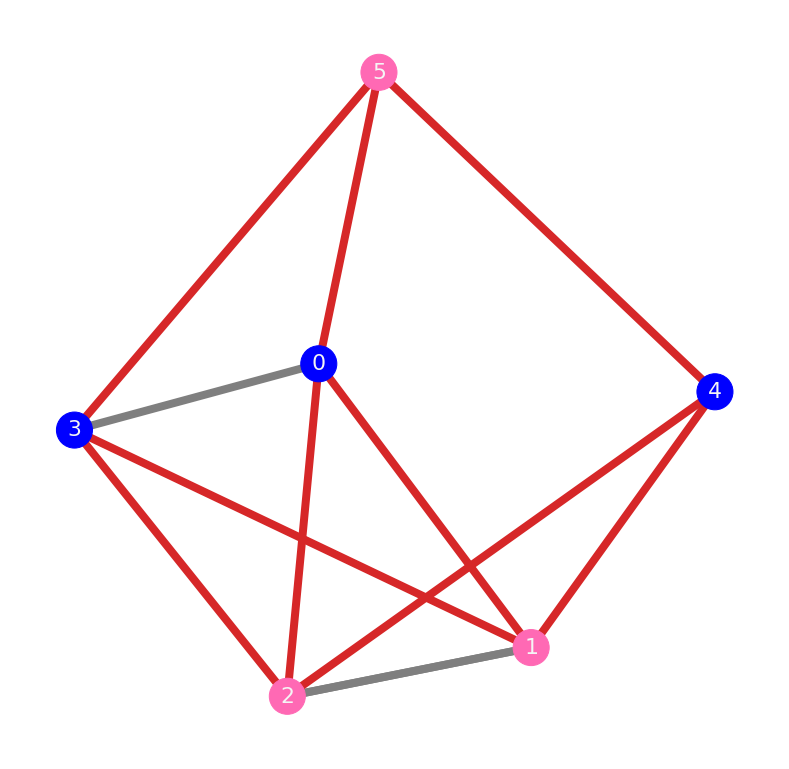

In [535]:
a = list(map(int,list(simresult.found_solution)))
graph_drawing(G_model_6,'done',bitstring = a,filename = 'done_graph6.png')

## Finally, consider a big graph of size 15

In [536]:
from random import randint
# create a list of edges
E_big = []
for i in range(60):
    x = randint(0, 20)
    y = randint(0, 20)
    if (x != y) and ((x,y) not in E_big):
        E_big.append((x,y))
print(*E_big)

(11, 15) (14, 7) (15, 4) (10, 5) (11, 5) (17, 6) (18, 12) (2, 9) (14, 19) (2, 7) (1, 11) (13, 12) (14, 9) (2, 4) (5, 14) (20, 12) (19, 0) (10, 12) (14, 3) (5, 9) (11, 19) (0, 16) (19, 1) (9, 19) (6, 4) (18, 4) (13, 11) (7, 1) (11, 17) (1, 4) (4, 10) (8, 20) (7, 2) (19, 12) (20, 19) (1, 13) (18, 3) (2, 13) (9, 13) (15, 0) (20, 11) (8, 14) (17, 11) (5, 0) (2, 1) (20, 16) (19, 17) (18, 1) (12, 7) (11, 10) (4, 1) (18, 7) (18, 16)


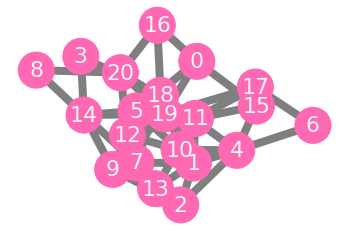

In [538]:
# Graph description for the certain task
n_qubits = 16
G_model_big = GraphModel(n_qubits,E_big)
G_big = G_model_big.graph
G_model_big.draw_raw_graph()

In [539]:
p = 10
initial_parameters = [1.0,1.0]*p
model = QAOA(G_big,initial_parameters)
counts = model.counts

In [496]:
simresult = SimResult(counts,G_big)
simresult.calc_result()
simresult.show_result()


 --- SIMULATION RESULTS ---

The approximate solution is x* = [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1] with C(x*) = 40 



IndexError: list index out of range

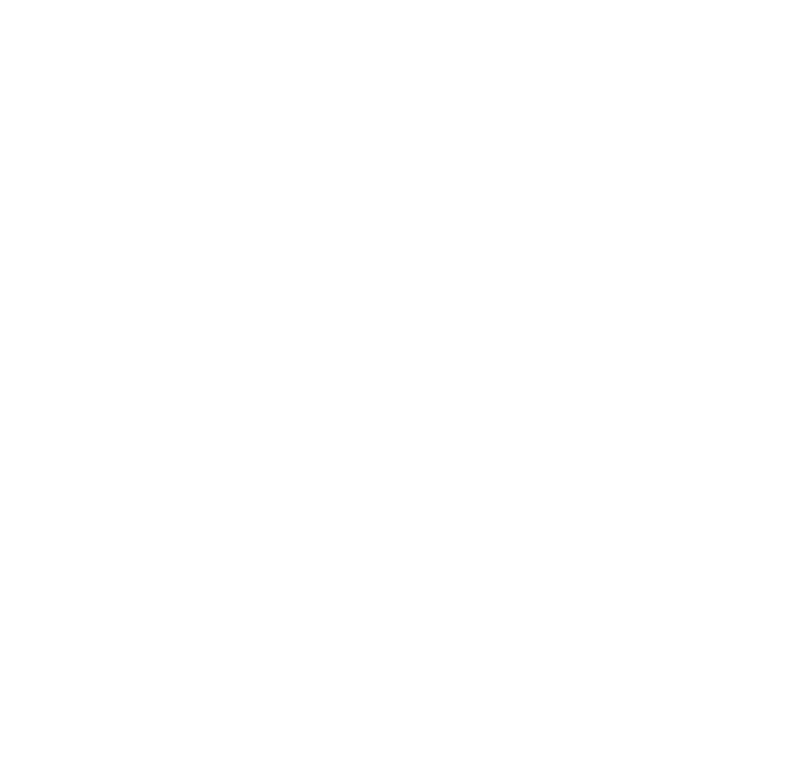

In [537]:
a = list(map(int,list(simresult.found_solution)))
graph_drawing(G_model_big,'done',bitstring = a,filename = 'done_graph_big.png')

In [498]:
plot_histogram(model.counts, figsize=(16, 10), color=None, number_to_keep=None,
               sort='asc', target_string=None, legend=None,
               bar_labels=False, title="Final Distribution", ax=None, filename="final_distr_big")